# Multiclass obesity risk prediction

## 1 - Imports

In [185]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler

import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()


In [144]:
data = pd.read_csv("data/train.csv")
submission_data = pd.read_csv("data/test.csv")

## 2 - Exploratory Data Analysis

### 2.1 - Structure investigation

What is this general structure of the dataset ? 

In [4]:
data.shape

(20758, 18)

In [5]:
data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


**Features dictionary** : 
- Eating habits : 
    - FAVC : Frequent consumption of high caloric food.
    - FCVC: Frequency of consumption of vegetables.
    - NCP : Number of main meals
    - CAEC : Consumption of food between meals
    - CH20 : Consumption of water daily
    - CALC : Consumption of alcohol
- Physical condition : 
    - SCC : Calories consumption monitoring.
    - FAF : Physical activity frequency.
    - TUE : Time using technology devices.
    - MTRANS : Transportation used.

(information found here https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster)

No need for id column:

In [145]:
data = data.drop('id', axis=1)

Checking out dtypes :

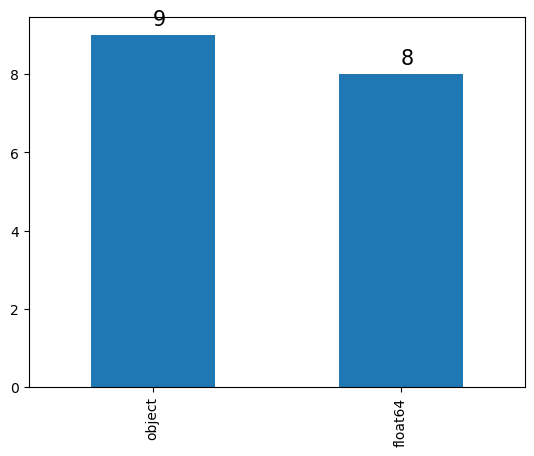

In [40]:
ax = data.dtypes.value_counts().plot.bar()
for bar in ax.patches:
    ax.annotate(str(bar.get_height()), (bar.get_x()+ bar.get_width() / 2, bar.get_height() + 0.25), size=15)
plt.show()

<Axes: >

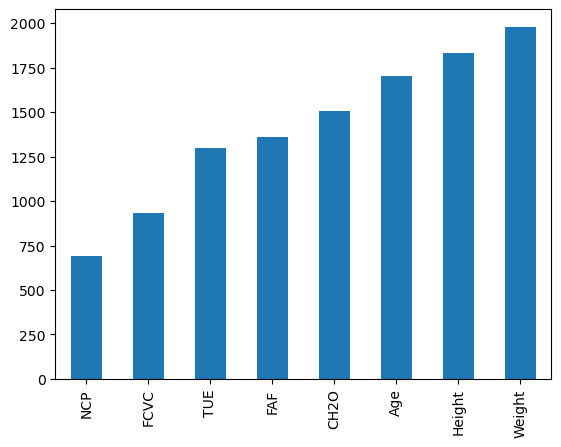

In [54]:
data.select_dtypes(include='number').nunique().sort_values().plot.bar()

All features that are numerical have high number of unique values, which means there is no categorical variable that was interpreted as numerical (for example there is no binary feature whose values are 0 and 1 instead of True and False strings)

In [56]:
data.select_dtypes(exclude='number').describe()

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad
count,20758,20758,20758,20758,20758,20758,20758,20758,20758
unique,2,2,2,4,2,2,3,5,7
top,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation,Obesity_Type_III
freq,10422,17014,18982,17529,20513,20071,15066,16687,4046


### 2.2 - Quality investigation

#### Checking for duplicates

In [59]:
data.duplicated().sum()

0

#### Checking for missing values

In [62]:
data.isna().sum().sum()

0

### 2.3 - Content investigation

#### 2.3.1 - Distributions :

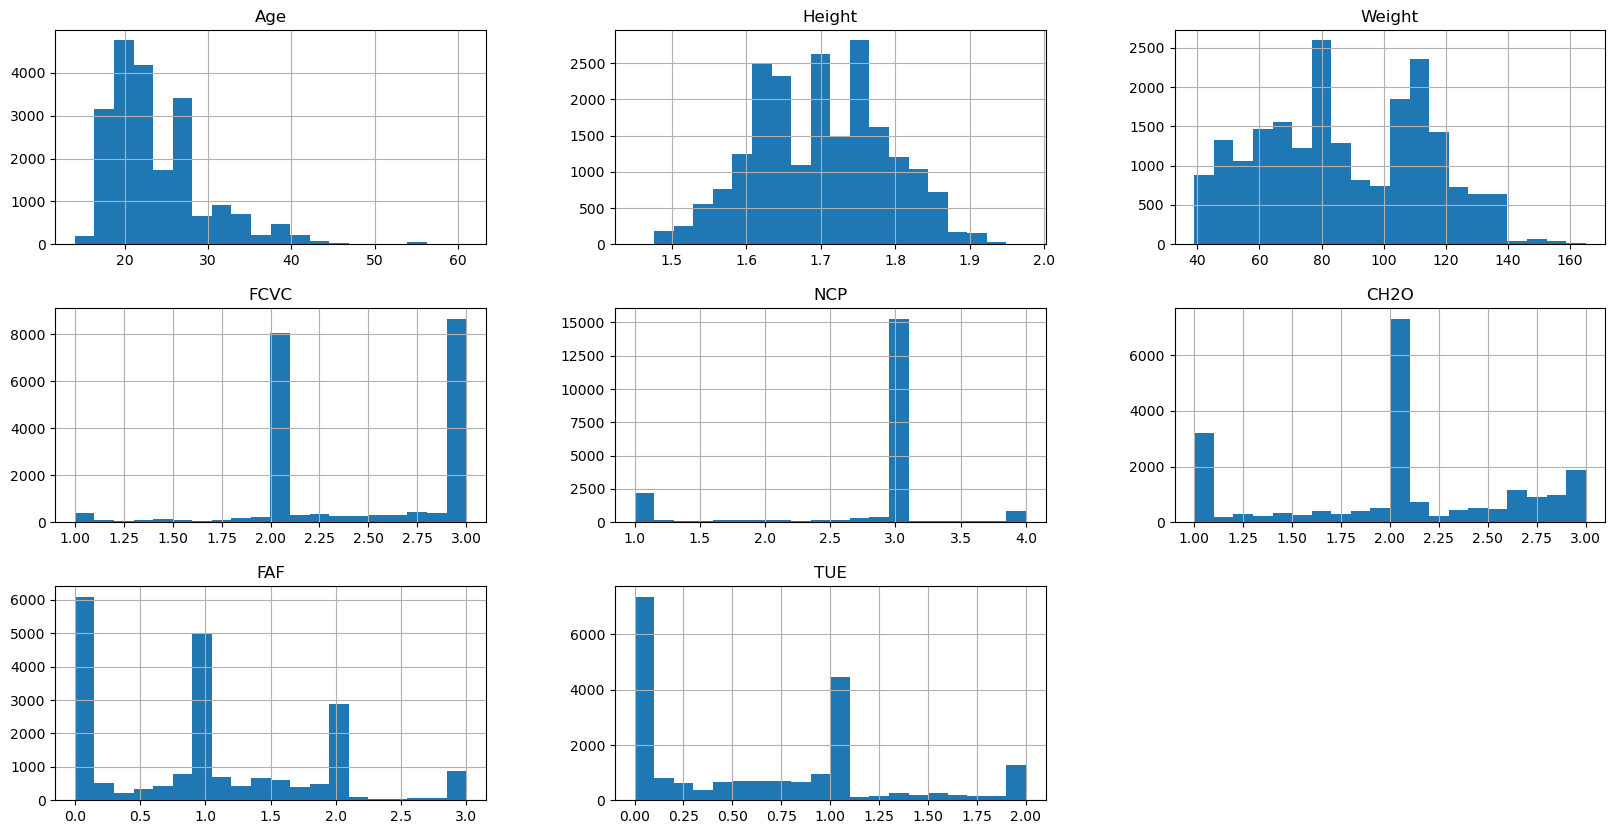

In [83]:
data.hist(bins=20, figsize=(20,10))
plt.show()

Age, Height, and weight are as expected normally distributed (or almost).

The other features display high peaks at some specific rounded up (or down) values. For example, a feature like NCP has 95% of its values either be 1, 3, or 4, it will probably be considered as a categorical variable by most machine learning models, as they will retain the fact that the features gets most of its values from an ensembles of 3 integers.

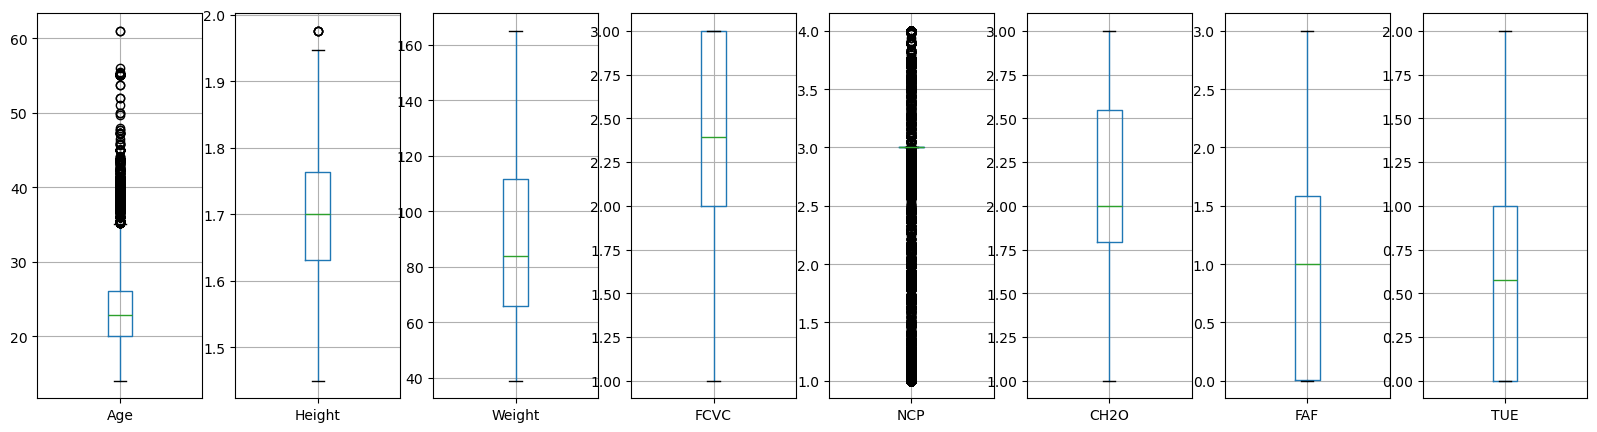

In [90]:
fig = plt.figure(figsize=(20,5))
axes = fig.subplots(1,8)
for i,column in enumerate(data.select_dtypes(include='number').columns):
    data.boxplot(column, ax=axes.flatten()[i])
plt.show()

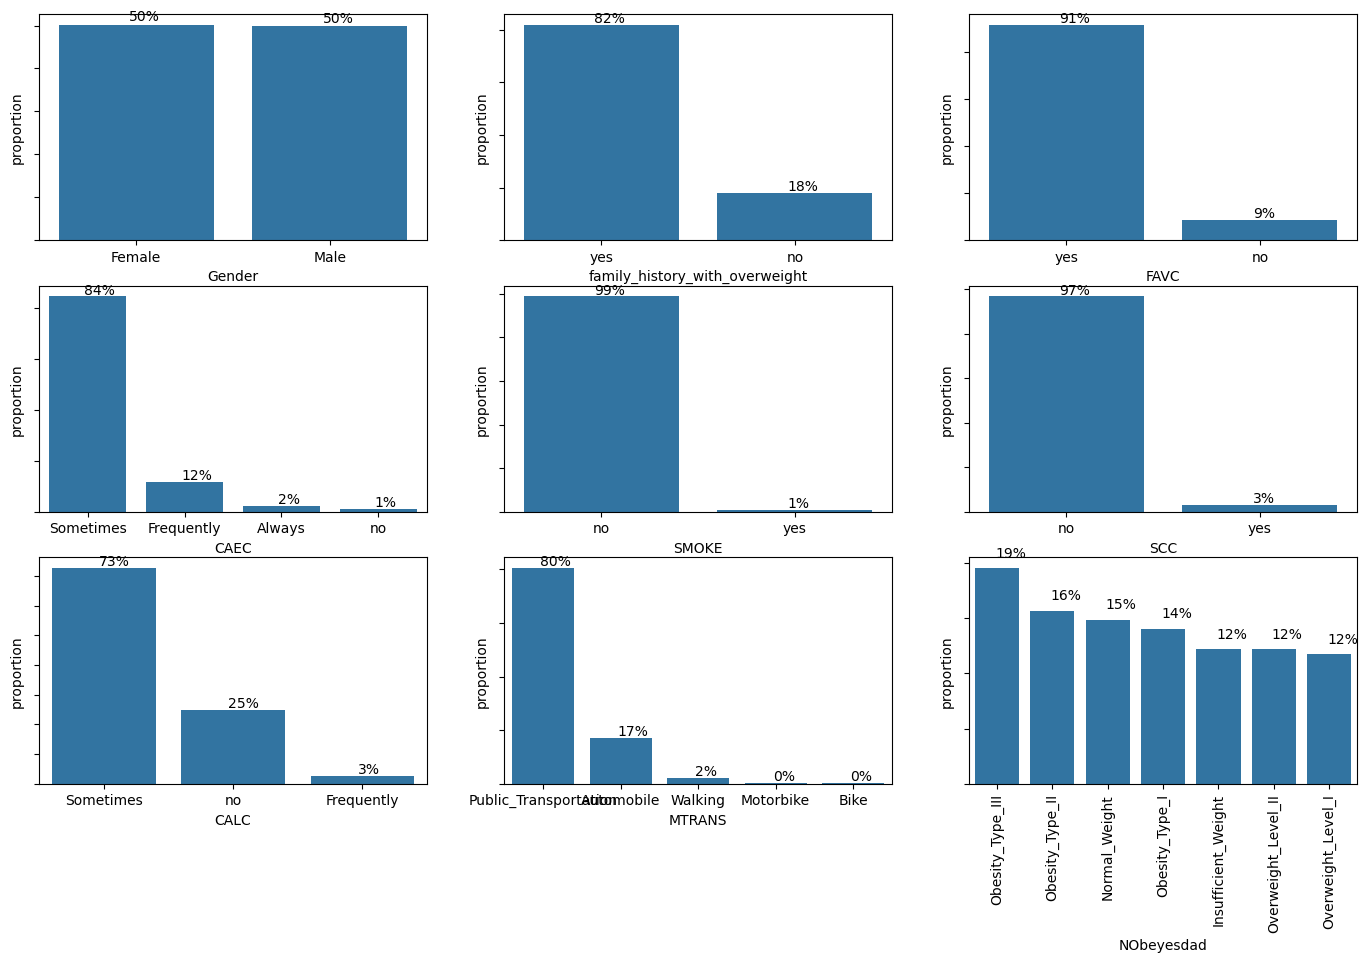

In [24]:
fig = plt.figure(figsize=(17,10))
axes = fig.subplots(3,3)
for i,column in enumerate(data.select_dtypes(exclude='number').columns):
    ax = sns.barplot(data[column].value_counts(normalize=True), ax=axes.flatten()[i])
    ax.set(yticklabels=[])
    for bar in ax.patches:
        ax.annotate(str((round(bar.get_height()*100))) + '%', (bar.get_x() + bar.get_width()/2.2, bar.get_height()+0.01))
plt.xticks(rotation=90)
plt.show()

Target variable classes are well balanced, but independant variables (besides gender) are very imbalanced, especially the binary ones.\
Imbalanced categorical features are usually not a big issue for Machine Learning models, but an iterative feature selection process can be done to figure out whether feeding them to the model should be done. 

#### 2.3.2 - Features relationships:

<Axes: xlabel='Weight', ylabel='Height'>

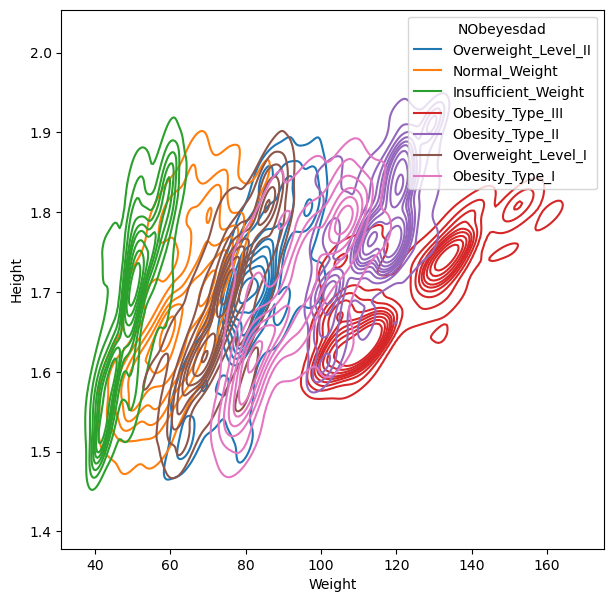

In [52]:
plt.figure(figsize=(7,7))
sns.kdeplot(data, x='Weight', y='Height',  hue='NObeyesdad')

Thanks to the above joint distribution plot, we can identify the ranges of weight and height for each weight type (from underweight to overweight). As expected, the weight is the dominant variable when it comes to determining the obesity type.

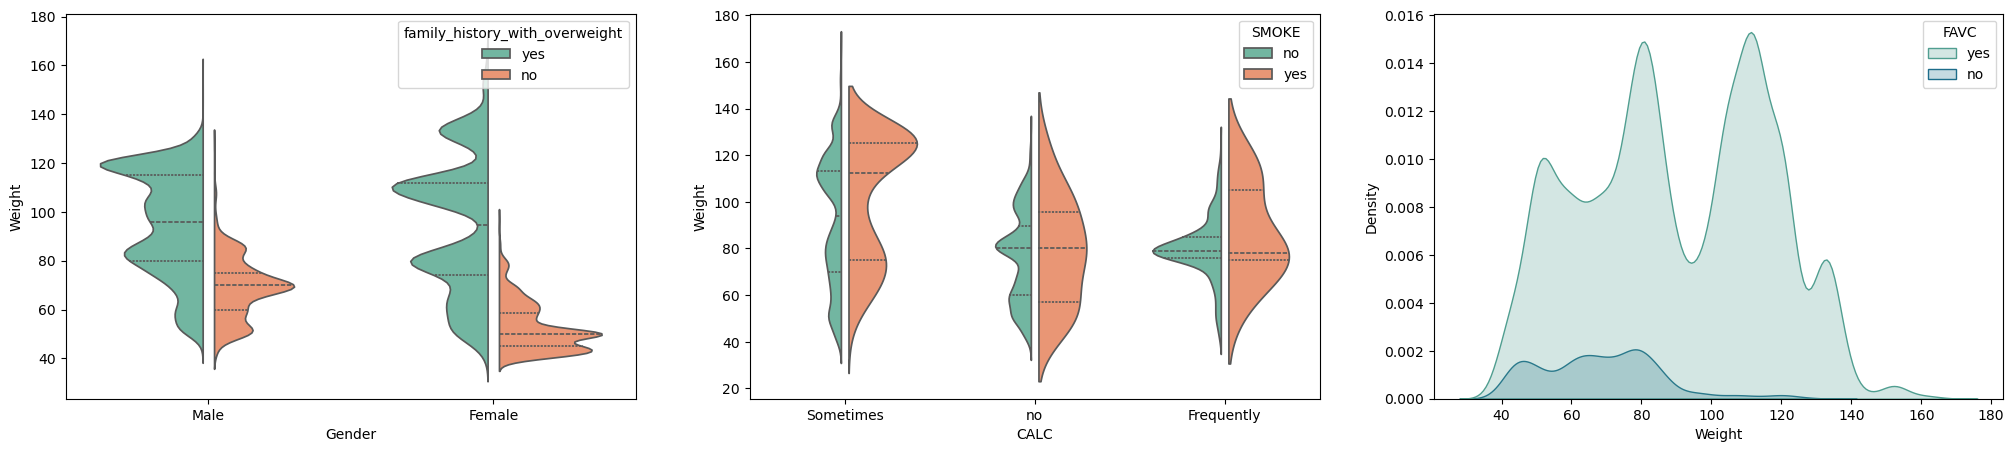

In [55]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
sns.violinplot(data, x='Gender', y='Weight', hue='family_history_with_overweight', palette="Set2", inner="quart", gap=.1, split=True)
plt.subplot(1,3,2)
sns.violinplot(data, x='CALC', y='Weight', hue='SMOKE', palette="Set2", split=True, inner="quart", gap=.1)
plt.subplot(1,3,3)
sns.kdeplot(data, x='Weight', hue='FAVC', fill=True, palette='crest')
plt.show()

- People who have family history with obesity are at a clear higher risk of being obese themselve, this is particularly true for women.
- People who drink sometimes have higher chances of being overweight than those who drink frequently or don't drink at all. This data is probably biased and doesn't mean drinking frequently is better than at occasions.
- People who smoke are more inclined to be overweight or underweight than those who don't, especially when paired up with alcohol.

<Axes: >

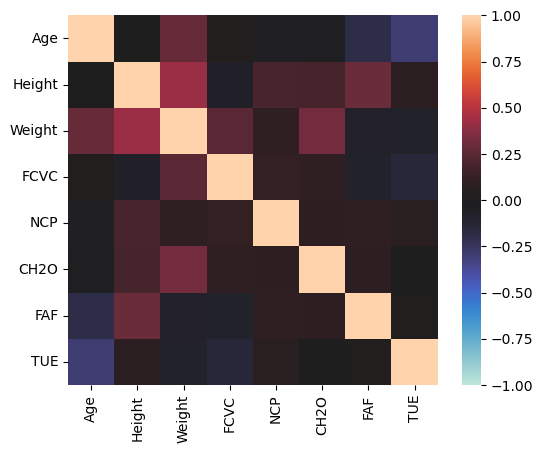

In [31]:
df_corr=data.select_dtypes(include='number').corr(method='pearson')
sns.heatmap(df_corr, square=True, vmin=-1, vmax=1, center=0)

Lack of great correlation coefficients, meaning there is no significant linear correlation between features. 

#### 2.3.3 - Hypothesis testing dependencies : 

## 3 - Preprocessing

Standard scaling:

In [146]:
numerical_columns = data.select_dtypes(include='number').columns
standard_scaler = StandardScaler()
data[numerical_columns] = standard_scaler.fit_transform(data[numerical_columns])

Ordinal embedding for categorical variables:

In [135]:
categorical_columns = data.select_dtypes(exclude='number').columns

ordinal_encoder = OrdinalEncoder()
data[categorical_columns] = ordinal_encoder.fit_transform(data[categorical_columns])

label_encoder = LabelEncoder()
label_encoder.fit(data['NObeyesdad'])
data['NObeyesdad'] = label_encoder.transform(data['NObeyesdad'])

In [159]:
label_encoder = LabelEncoder()
label_encoder.fit(data['NObeyesdad'].copy())
data['NObeyesdad'] = label_encoder.transform(data['NObeyesdad'])

Splitting features and target variable:

In [118]:
data = data.to_numpy()
X = data[:, :-1]
y = data[:, -1]

## 4 - Modelization and training 

### 4.1 - Decision Tree:

In [71]:
decision_tree = DecisionTreeClassifier()
param_grid_dt = {
    'max_depth' : [5, 6, 7, 8, 9, 10, 11, 12],
    'criterion' :['gini', 'entropy']
}
grid_search_dt = GridSearchCV(decision_tree, param_grid=param_grid_dt, cv=6, scoring='accuracy')
grid_search_dt.fit(X, y)

GridSearchCV(cv=6, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12]},
             scoring='accuracy')

In [72]:
grid_search_dt.best_score_

0.8767710632841305

### 4.2 - Random Forest:

In [60]:
random_forest = RandomForestClassifier()
random_forest.fit(train_x, train_y)

param_grid_rf = {
    "n_estimators" : [100],
    'max_depth' : [5, 6, 7, 8, 9, 10, 11, 12],
    'criterion' :['gini', 'entropy']
}
grid_search_rf = GridSearchCV(random_forest, param_grid=param_grid_rf, cv=6, scoring='accuracy')
grid_search_rf.fit(X, y)

GridSearchCV(cv=6, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
                         'n_estimators': [100]},
             scoring='accuracy')

In [64]:
grid_search_rf.best_score_

0.8980636785108908

### 4.3 - Gradient boosting:

In [71]:
param_grid_xgb = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': range(5, 11)
}
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=7)
grid_search_xgb = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=6, scoring='accuracy')
grid_search_xgb.fit(X,y)

GridSearchCV(cv=6,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=7,
                                     num_parallel_tree=None, ...),
             param_grid={'max_depth': range(5, 11),
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [70]:
grid_search_xgb.best_score_

0.9080356680319582

### 4.4 - Multi-layer perceptron:

In [ ]:
y_onehot = to_categorical(y)

def mlp_model_builder():
    mlp_model = Sequential()
    mlp_model.add(Dense(16, input_shape=(X.shape[1],), kernel_initializer="he_normal", activation='relu'))
    mlp_model.add(Dense(32, kernel_initializer="he_normal", activation='relu'))
    mlp_model.add(Dense(16, kernel_initializer="he_normal", activation='relu'))
    mlp_model.add(Dense(y_onehot.shape[1], kernel_initializer="he_normal", activation='softmax'))
    mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return mlp_model

mlp_model_wrapper = KerasClassifier(build_fn=mlp_model_builder, epochs=40, batch_size=12, verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
mlp_results = cross_val_score(mlp_model_wrapper, X, y_onehot, cv=kfold, scoring="accuracy")
print(sum(mlp_results)/len(mlp_results))

The model displaying best average score on 6 folds cross-validation is XGBoost. 

## 5 - Generating test submission:

In [165]:
submission_data[numerical_columns] = standard_scaler.transform(submission_data[numerical_columns])

ordinal_encoder_test = OrdinalEncoder()
submission_data[categorical_columns[:-1]] = ordinal_encoder_test.fit_transform(submission_data[categorical_columns[:-1]])

submission_data = submission_data.to_numpy()
submission_y = grid_search_xgb.predict(submission_data[:, 1:])
submission_y = label_encoder.inverse_transform(submission_y)

In [177]:
submission_df = pd.concat([pd.DataFrame(submission_data[:, 0].astype('int')), pd.DataFrame(submission_y)], axis=1)
submission_df.columns = ['id', 'NObeyesdad']
submission_df.to_csv('submission.csv', index=False)

Xgboost model submission scores : 
- Score: 0.89306
- Public score: 0.90317

